In [1]:
from numpy.random import seed, choice, random
from C_E_VRP_TW import  CG_VRP_TW, Constructive, Genetic, Feasibility, Reparator
from time import time

In [2]:
'''
Environment and general parameters
'''
env = CG_VRP_TW()
# instance = 'c101C5.txt'
instance = 'rc108_21.txt'
env.load_data(instance)
env.generate_parameters()
rd_seed = 0
seed(rd_seed)
Phases = {}



'''
Constructive heuristic
'''
constructive = Constructive()
RCL_alpha = 0.5             # RCL alpha
RCL_mode = 'Hybrid'
End_slack = 20               # Slack to send veicles to depot



'''
Genetic algorithm
'''
Population_size = 1000   
Elite_size = int(Population_size * 0.05)

genetic = Genetic(Population_size, Elite_size)
max_generations = 100
max_time = 3600

crossover_rate = 0.35
mutation_rate = 0.35



'''
Feasibility operators
'''
feas_op = Feasibility()



'''
Repair operators
'''
repair_op = Reparator()
repair_op.reset(env)

In [3]:
'''
------------------------------------------------------------------------------------------------
Initial Population
------------------------------------------------------------------------------------------------
- Population: (list of lists) Each individual's routes
- Objectives: (list of int) Each individual's total time
- Distances: (list of list) Each individual's total distance
- Times: (list of list) Each individual's route's time
- Resluts: (list of lists of lists): Each individual's [q,k]
'''
start = time()
const_parameters = (env, RCL_alpha, RCL_mode, End_slack)
Population, Distances, Times, Details = genetic.generate_population(constructive, const_parameters)
generation = 0
Phases['Constructive'] = round(time() - start,2)

incumbent = 1e9
best_individual, Incumbents = [], []
for i in range(Population_size):
    if Distances[i] < incumbent:
        incumbent = Distances[i]
        best_individual = [Population[i], Distances[i], Times[i], Details[i]]
Incumbents.append(incumbent)

genetic.print_initial_population(env, start, Population, Distances, feas_op)
print(f'Best generated individual {best_individual[0]} \n')


###################   Initial Population   ####################

Total generation time: 14.003499031066895 s
Number of individuals: 1000
Best generated individual:  2601.41
Worst generated individual: 3519.28
Number of unfeasible individuals: 0


Best generated individual [['D', 'C55', 'C53', 'C65', 'C64', 'C83', 'S15', 'D'], ['D', 'C67', 'C71', 'C72', 'C96', 'D'], ['D', 'C57', 'C87', 'C13', 'C10', 'C11', 'C9', 'S11', 'D'], ['D', 'C99', 'C66', 'C95', 'C84', 'C56', 'S15', 'D'], ['D', 'C100', 'C88', 'C70', 'C7', 'C6', 'C2', 'S7', 'D'], ['D', 'C42', 'C44', 'C93', 'S1', 'D'], ['D', 'C91', 'C98', 'C90', 'C80', 'D'], ['D', 'C81', 'C68', 'C61', 'C41', 'C54', 'D'], ['D', 'C82', 'C86', 'C58', 'C74', 'S14', 'D'], ['D', 'C62', 'C49', 'C19', 'C18', 'C48', 'S16', 'D'], ['D', 'C69', 'C16', 'C73', 'C78', 'S10', 'D'], ['D', 'C85', 'C20', 'C24', 'C22', 'S16', 'D'], ['D', 'C4', 'C45', 'C79', 'C60', 'S9', 'D'], ['D', 'C94', 'C92', 'C33', 'S18', 'D'], ['D', 'C8', 'C46', 'C3', 'C5', 'C1', 'S7', 'D'], ['D'


###################   Generation 50   ####################

Total evolution time: 590.9090240001678 s
Number of individuals: 1000
Best generated individual (dist): 2302.6739442045805
Number of unfeasible individuals: 0



###################   Generation 100   ####################

Total evolution time: 1142.6388289928436 s
Number of individuals: 1000
Best generated individual (dist): 2288.9127231520256
Number of unfeasible individuals: 0



###################   Generation 101   ####################

Total evolution time: 1154.7131369113922 s
Number of individuals: 1000
Best generated individual (dist): 2288.9127231520256
Number of unfeasible individuals: 0


[['D', 'C68', 'C43', 'C36', 'C44', 'C38', 'C37', 'C35', 'S4', 'D'], ['D', 'C61', 'C41', 'C39', 'C40', 'C42', 'S3', 'C72', 'C54', 'C81', 'C96', 'D'], ['D', 'C94', 'C62', 'C89', 'S17', 'D'], ['D', 'C64', 'C10', 'C11', 'C13', 'C15', 'C16', 'S12', 'D'], ['D', 'C65', 'C71', 'C80', 'C90', 'D'], ['D', 'C57', 'C58', 'C99', 'S13', 'D'], 

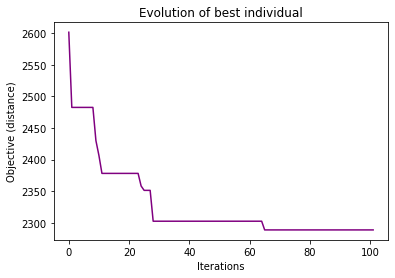

In [4]:
'''
------------------------------------------------------------------------------------------------
Genetic proccess
------------------------------------------------------------------------------------------------
'''
start_g = time()

while generation <= max_generations and time() - start_g <= max_time:
    generation += 1

    ### Selecting elite class
    Elite = [x for _, x in sorted(zip(Distances,[i for i in range(Population_size)]))][:Elite_size] 


    ### Selection: From a population, which parents are able to reproduce
    # Fitness function
    tots = sum(Distances)
    probs = [Distances[i]/tots for i in range(len(Distances))]
    

    # Intermediate population: Sample of the initial population    
    inter_population = choice([i for i in range(Population_size)], size = int(Population_size - Elite_size), replace = True, p = probs)
    inter_population = Elite + list(inter_population)


    ### Tournament: Select two individuals and leave the best to reproduce
    Parents = genetic.tournament(inter_population, Distances)
    

    ### Recombination: Combine 2 parents to produce 1 offsprings 
    New_chorizos = []
    for index in range(len(Parents)):
        couple = Parents[index]
        chosen_parent = choice([couple[0], couple[1]])
        chorizo = repair_op.build_chorizo(env, Population[chosen_parent])
        
        if random() < crossover_rate:
            new_chorizo = genetic.crossover(env, Population[chosen_parent], chorizo, repair_op)
        else:
            new_chorizo = chorizo
    
        New_chorizos.append(new_chorizo)


    ### Mutation: 'Shake' an individual
    

    ### Repair solutions
    Population, Distances, Times = [],[],[]
    for i in range(Population_size):
        parent, distance, distances, ttime, times  = repair_op.repair_chorizo(env, New_chorizos[i], RCL_alpha, RCL_mode, End_slack)

        Population.append(parent);  Distances.append(distance); 
        Times.append(times)#;  Details.append((distances, times))

        if distance < incumbent:
            incumbent = distance
            best_individual = [parent, distance, ttime, (distances, times)]
        
    if generation % 50 == 0:
        genetic.print_evolution(env, start, Population, generation, Distances, feas_op, incumbent)

    Incumbents.append(incumbent)
    
    
genetic.print_evolution(env, start, Population, generation, Distances, feas_op, incumbent)
print(f'Best found individual: {best_individual[0]}')

env.plot_evolution(Incumbents)

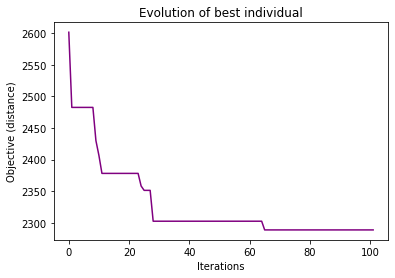

In [8]:
env.plot_evolution(Incumbents)

Text(0, 0.5, 'Incumbent')

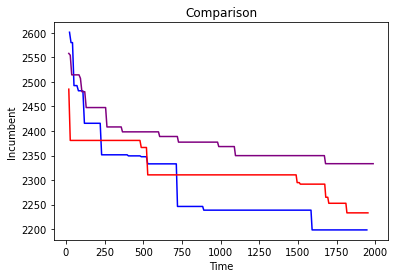

In [10]:
import matplotlib.pyplot as plt
res = [([2601.4088471799514, 2580.2974590294352, 2580.2974590294352, 2492.61695971486, 2492.61695971486, 2492.61695971486, 2482.0476308155767, 2482.0476308155767, 2482.0476308155767, 2481.734890009419, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2415.744741231511, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2351.4555679040927, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2349.2733922716075, 2347.576005940236, 2347.576005940236, 2347.576005940236, 2347.576005940236, 2347.576005940236, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2333.000786209182, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2246.148050013135, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2238.581519865638, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133, 2198.2783528904133], [23.42, 33.08, 42.69, 52.29, 61.83, 71.39, 81.0, 90.57, 100.11, 109.99, 119.76, 129.21, 138.63, 147.99, 157.36, 166.74, 176.07, 185.33, 194.59, 203.72, 212.79, 221.81, 231.05, 240.41, 249.62, 258.62, 267.29, 276.24, 285.16, 294.2, 302.97, 311.47, 320.26, 328.85, 337.42, 345.83, 354.19, 362.53, 370.82, 379.26, 387.53, 395.91, 404.29, 412.59, 420.88, 429.21, 437.49, 445.77, 454.15, 462.48, 470.75, 479.1, 487.42, 495.74, 504.09, 512.47, 520.71, 529.01, 537.33, 545.56, 553.86, 562.05, 570.24, 578.53, 586.7, 594.8, 602.96, 611.12, 619.17, 627.23, 635.23, 643.23, 651.23, 659.2, 667.06, 675.0, 682.87, 690.69, 698.5, 706.19, 713.91, 721.62, 729.26, 736.82, 744.41, 751.91, 759.34, 766.74, 774.16, 781.51, 788.84, 796.13, 803.42, 810.74, 818.01, 825.49, 833.19, 840.72, 848.0, 855.26, 862.59, 869.88, 877.1, 884.44, 891.73, 899.0, 906.25, 913.45, 920.8, 928.09, 935.34, 942.53, 949.79, 956.99, 964.26, 971.52, 978.78, 986.03, 993.23, 1000.48, 1007.67, 1014.8, 1022.01, 1029.19, 1036.34, 1043.55, 1050.81, 1058.01, 1065.24, 1072.41, 1079.6, 1086.76, 1093.99, 1101.15, 1108.35, 1115.53, 1122.74, 1129.94, 1137.1, 1144.3, 1151.53, 1158.64, 1165.77, 1172.98, 1180.16, 1187.39, 1194.61, 1201.85, 1209.04, 1216.16, 1223.36, 1230.49, 1237.67, 1244.92, 1252.15, 1259.33, 1266.46, 1273.62, 1280.79, 1288.05, 1295.3, 1302.46, 1309.62, 1316.81, 1324.03, 1331.22, 1338.39, 1345.57, 1352.75, 1359.97, 1367.15, 1374.28, 1381.46, 1388.69, 1395.82, 1403.0, 1410.22, 1417.38, 1424.82, 1432.24, 1439.71, 1446.89, 1454.1, 1461.22, 1468.34, 1475.61, 1482.79, 1490.02, 1497.16, 1504.37, 1511.6, 1519.01, 1526.45, 1534.07, 1541.63, 1548.88, 1556.04, 1563.26, 1570.52, 1577.69, 1584.93, 1592.14, 1599.36, 1606.58, 1613.82, 1620.98, 1628.16, 1635.46, 1642.61, 1649.78, 1656.97, 1664.26, 1671.47, 1678.64, 1685.89, 1693.09, 1700.3, 1707.52, 1714.72, 1721.91, 1729.07, 1736.28, 1743.51, 1750.74, 1757.89, 1765.12, 1772.41, 1779.69, 1786.86, 1794.08, 1801.34, 1808.56, 1815.79, 1823.11, 1830.31, 1837.49, 1844.84, 1852.06, 1859.27, 1866.52, 1873.74, 1880.97, 1888.25, 1895.48, 1902.73, 1910.02, 1917.21, 1924.48, 1931.73, 1938.9, 1946.08]), ([2485.297985845561, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2380.7883434036276, 2366.3804897217497, 2366.3804897217497, 2366.3804897217497, 2366.3804897217497, 2366.3804897217497, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2310.5395861501656, 2294.771413041929, 2294.771413041929, 2294.771413041929, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2291.634663331917, 2264.8777738670237, 2264.8777738670237, 2264.8777738670237, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2252.6109987328114, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636, 2233.0665933970636], [18.72, 28.18, 37.53, 46.93, 56.31, 65.78, 75.09, 84.79, 94.57, 103.85, 113.11, 122.31, 131.54, 140.74, 149.93, 159.06, 168.15, 177.25, 186.33, 195.38, 204.37, 213.38, 222.29, 231.3, 240.18, 249.04, 257.92, 266.71, 275.48, 284.14, 292.82, 301.44, 310.07, 318.67, 327.18, 335.73, 344.2, 352.69, 361.18, 369.64, 378.11, 386.57, 394.98, 403.44, 411.81, 420.15, 428.44, 436.81, 445.31, 453.72, 462.12, 470.47, 478.87, 487.29, 495.67, 504.08, 512.55, 520.9, 529.28, 537.63, 546.21, 554.58, 563.01, 571.38, 579.8, 588.15, 596.47, 604.83, 613.3, 621.64, 629.99, 638.41, 646.86, 655.28, 663.77, 672.17, 680.89, 689.66, 698.19, 706.5, 714.85, 723.16, 731.44, 739.74, 747.96, 756.19, 764.54, 772.81, 781.08, 789.37, 797.62, 805.78, 814.01, 822.24, 830.39, 838.58, 846.76, 854.98, 863.19, 871.35, 879.54, 887.75, 895.92, 904.03, 912.11, 920.21, 928.29, 936.32, 944.39, 952.56, 960.62, 968.72, 976.77, 984.74, 992.79, 1000.71, 1008.72, 1016.76, 1024.77, 1032.75, 1040.81, 1048.84, 1056.88, 1064.95, 1072.98, 1081.04, 1089.01, 1097.03, 1105.05, 1113.06, 1121.05, 1129.06, 1137.06, 1145.04, 1153.03, 1161.03, 1168.98, 1176.91, 1184.87, 1192.83, 1200.79, 1208.77, 1216.68, 1224.57, 1232.49, 1240.43, 1248.31, 1256.24, 1264.16, 1272.0, 1280.04, 1287.94, 1295.87, 1303.57, 1311.17, 1318.62, 1326.19, 1333.69, 1341.02, 1348.21, 1355.46, 1362.57, 1369.69, 1376.85, 1383.99, 1391.01, 1398.16, 1405.18, 1412.26, 1419.36, 1426.41, 1433.49, 1440.46, 1447.38, 1454.29, 1461.17, 1468.04, 1474.94, 1481.85, 1488.71, 1495.52, 1502.31, 1509.13, 1515.91, 1522.67, 1529.39, 1536.01, 1542.68, 1549.3, 1555.92, 1562.51, 1569.17, 1575.75, 1582.29, 1588.85, 1595.37, 1601.89, 1608.45, 1615.0, 1621.52, 1628.09, 1634.67, 1641.19, 1647.7, 1654.32, 1660.79, 1667.33, 1673.89, 1680.48, 1686.99, 1693.48, 1700.06, 1706.55, 1712.98, 1719.45, 1725.97, 1732.51, 1739.03, 1745.49, 1752.03, 1758.52, 1764.97, 1771.49, 1778.05, 1784.6, 1791.12, 1797.69, 1804.19, 1810.67, 1817.21, 1823.66, 1830.1, 1836.53, 1843.0, 1849.53, 1855.95, 1862.32, 1868.77, 1875.14, 1881.89, 1888.53, 1895.17, 1901.6, 1908.04, 1914.45, 1920.86, 1927.28, 1933.73, 1940.26, 1946.75, 1953.16]), ([2558.2295146813144, 2554.5707687512026, 2514.50358330596, 2514.50358330596, 2514.50358330596, 2514.50358330596, 2514.50358330596, 2514.50358330596, 2507.3869370054913, 2480.1265473904255, 2480.1265473904255, 2480.1265473904255, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2447.820051176307, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2408.2809118662244, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2398.2794235778747, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2388.807573399008, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2377.296543530539, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2368.271726642005, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2349.781693136092, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517, 2333.343916511517], [18.76, 28.2, 37.67, 47.1, 56.54, 65.98, 75.38, 84.68, 94.04, 103.44, 112.71, 121.98, 131.25, 140.5, 149.74, 158.85, 167.88, 176.97, 185.95, 194.85, 203.72, 212.61, 221.47, 230.33, 239.19, 247.96, 256.85, 265.51, 274.1, 282.69, 291.19, 299.63, 308.08, 316.42, 324.76, 333.04, 341.31, 349.48, 357.71, 365.81, 373.86, 381.91, 389.89, 397.84, 405.82, 413.75, 421.63, 429.48, 437.27, 445.02, 452.74, 460.43, 468.16, 475.88, 483.52, 491.19, 498.8, 506.44, 514.13, 521.81, 529.66, 537.71, 545.35, 553.01, 560.62, 568.27, 575.86, 583.49, 591.09, 598.72, 606.4, 613.97, 621.58, 629.09, 636.65, 644.3, 651.87, 659.41, 667.08, 674.65, 682.24, 689.91, 697.58, 705.27, 712.93, 720.57, 728.2, 735.85, 743.44, 751.03, 758.69, 766.35, 773.99, 781.68, 789.32, 796.98, 804.69, 812.33, 820.0, 827.7, 835.36, 843.02, 850.67, 858.27, 865.89, 873.58, 881.24, 888.85, 896.49, 904.1, 911.79, 919.56, 927.28, 934.98, 942.68, 950.35, 957.92, 965.51, 973.17, 980.76, 988.4, 996.0, 1003.63, 1011.26, 1019.08, 1027.16, 1035.22, 1043.01, 1050.69, 1058.39, 1066.0, 1073.69, 1081.32, 1089.01, 1096.63, 1104.29, 1112.01, 1119.57, 1127.46, 1135.48, 1143.21, 1150.79, 1158.44, 1166.07, 1173.8, 1181.51, 1189.19, 1196.85, 1204.56, 1212.19, 1219.83, 1227.56, 1235.27, 1242.96, 1250.63, 1258.22, 1265.86, 1273.54, 1281.18, 1288.82, 1296.5, 1304.21, 1311.91, 1319.63, 1327.28, 1334.91, 1342.56, 1350.22, 1357.93, 1365.61, 1373.28, 1380.96, 1388.54, 1396.19, 1403.77, 1411.34, 1419.02, 1426.69, 1434.4, 1442.18, 1449.93, 1457.64, 1465.32, 1472.91, 1480.55, 1488.27, 1495.87, 1503.51, 1511.16, 1518.85, 1526.47, 1534.11, 1541.78, 1549.4, 1557.03, 1564.68, 1572.27, 1579.92, 1587.54, 1595.14, 1602.73, 1610.28, 1617.88, 1625.57, 1633.22, 1640.86, 1648.51, 1656.13, 1663.78, 1671.4, 1679.08, 1686.73, 1694.39, 1702.05, 1709.71, 1717.33, 1725.05, 1732.98, 1740.88, 1748.79, 1756.5, 1764.3, 1772.03, 1779.78, 1787.7, 1795.43, 1803.14, 1810.85, 1818.6, 1826.31, 1833.96, 1841.71, 1849.4, 1857.09, 1864.8, 1872.41, 1880.03, 1887.68, 1895.26, 1902.84, 1910.47, 1918.09, 1925.77, 1933.4, 1940.99, 1948.67, 1956.28, 1963.95, 1971.59, 1979.26, 1986.92])]

first = res[0]
second = res[1]
third = res[2]

plt.plot(first[1], first[0][:-1], color = 'blue')
plt.plot(second[1], second[0][:-1], color = 'red')
plt.plot(third[1], third[0][:-1], color = 'purple')
plt.title('Comparison')
plt.xlabel('Time')
plt.ylabel('Incumbent')


In [7]:
parent = [['D', 'C100', 'C70', 'C55', 'C88', 'C98', 'C69', 'C90', 'C82', 'S13', 'D'], ['D', 'C80', 'C91', 'C92', 'C94', 'C62', 'C95', 'C56', 'S15', 'D'], ['D', 'C87', 'C59', 'C97', 'C13', 'C15', 'C16', 'S12', 'D'], ['D', 'C93', 'C71', 'C96', 'C54', 'C68', 'C81', 'D'], ['D', 'C65', 'C66', 'C83', 'C64', 'C84', 'C49', 'C19', 'S16', 'D'], ['D', 'C61', 'C99', 'C57', 'C52', 'S13', 'D'], ['D', 'C4', 'C45', 'C42', 'C44', 'S3', 'D'], ['D', 'C53', 'C60', 'C78', 'C73', 'C79', 'C6', 'C46', 'S7', 'D'], ['D', 'C67', 'C50', 'C26', 'C28', 'C27', 'S20', 'D'], ['D', 'C72', 'C41', 'C38', 'C39', 'C40', 'C36', 'C35', 'C37', 'C43', 'S3', 'D'], ['D', 'C10', 'C11', 'C12', 'C14', 'C47', 'C17', 'C9', 'S11', 'D'], ['D', 'C18', 'C48', 'C21', 'C76', 'S17', 'D'], ['D', 'C7', 'C2', 'C8', 'C5', 'C3', 'C1', 'S7', 'D'], ['D', 'C86', 'C74', 'C58', 'S14', 'D'], ['D', 'C51', 'C85', 'C63', 'C89', 'S17', 'D'], ['D', 'C24', 'C22', 'C20', 'C23', 'C25', 'C77', 'S14', 'D'], ['D', 'C34', 'C31', 'C29', 'C30', 'C32', 'C33', 'S18', 'D'], ['D', 'S13', 'C75', 'S14', 'D']]

visited = []
for route in parent:
    for node in route:
        if node in env.Costumers:
            if node in visited:
                print('Error')
            else:
                visited.append(node)
print(len(visited))

100


In [17]:
from numpy.random import randint

chorizo = [i for i in range(10)]

pos1 = randint(0, len(chorizo) - 3)
pos2 = randint(pos1 + 3, len(chorizo))

algo = [chorizo[pos2-i] for i in range(1,pos2-pos1)]
print(pos1)
print(pos2)
print(chorizo[:pos1+1] + algo + chorizo[pos2:])


2
7
[0, 1, 2, 6, 5, 4, 3, 7, 8, 9]
